In [56]:
import pickle
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import os
from collections import defaultdict
import re
import json
from collections import Counter
import dateutil
from dateutil import parser
from collections import defaultdict
from __future__ import division
import datetime
%pylab inline
from numpy import arange
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

Populating the interactive namespace from numpy and matplotlib


In [11]:
def parseint(string):
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [12]:
with open('movie_info_revised.p' ,'r') as picklefile:
    data = pickle.load(picklefile)

In [13]:
def date_helper(date):
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [14]:
history_keys_dic = defaultdict(dict)
for key in data.keys():
    if 'sequel' in data[key]['keywords']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_keys_dic['count'][year]= history_keys_dic['count'].get(year, 0) + 1  
history_df = pd.DataFrame.from_dict(history_keys_dic)
start = pd.datetime(1972, 1, 1)
end = pd.datetime(2016, 1, 1)
x = pd.date_range(start, end, freq='A').year
history_df_years = history_df.reindex(x)
history_df = history_df_years.fillna(0)
history_df['cumulative mean']=pd.expanding_mean(history_df['count']).shift(+1)
history_df['difference from mean']=history_df['count']/history_df['cumulative mean']

In [15]:
history_df

,count,cumulative mean,difference from mean
1972,4,NaN,NaN
1973,9,4.000000,2.250000
1974,9,6.500000,1.384615
1975,10,7.333333,1.363636
1976,8,8.000000,1.000000
1977,16,8.000000,2.000000
1978,12,9.333333,1.285714
1979,9,9.714286,0.926471
1980,7,9.625000,0.727273
1981,7,9.333333,0.750000


In [29]:
history_dic = defaultdict(dict)
for key in data.keys():
    if 'sequel' in data[key]['genre']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_dic[year][key]= defaultdict(dict)
            history_dic[year][key]['date']= data[key]['date']
            history_dic[year][key]['screens']= data[key]['screens']
            history_dic[year][key]['opening']= data[key]['opening']
                #space_dic['space'][year].append(key,)

In [30]:
history_dic

defaultdict(<type 'dict'>, {1972: {'The Mechanic': defaultdict(<type 'dict'>, {'date': '14 December 1972', 'screens': 'Error', 'opening': 'N/A'})}, 1973: {'The Exorcist': defaultdict(<type 'dict'>, {'date': '26 December 1973', 'screens': 'n/a', 'opening': 'n/a'}), 'Battle for the Planet of the Apes': defaultdict(<type 'dict'>, {'date': '15 June 1973', 'screens': 'Error', 'opening': 'N/A'}), 'The Tall Blond Man with One Black Shoe': defaultdict(<type 'dict'>, {'date': '30 August 1973', 'screens': 'Error', 'opening': 'N/A'})}, 1974: {'The Godfather: Part II': defaultdict(<type 'dict'>, {'date': '20 December 1974', 'screens': '', 'opening': 244000}), 'The Texas Chain Saw Massacre': defaultdict(<type 'dict'>, {'date': '4 October 1974', 'screens': 'Error', 'opening': 'N/A'}), 'The Three Musketeers': defaultdict(<type 'dict'>, {'date': '29 March 1974', 'screens': 'Error', 'opening': 'N/A'})}, 1975: {'Death Race 2000': defaultdict(<type 'dict'>, {'date': '27 April 1975', 'screens': 'n/a', 'op

In [31]:
def makedf(genre):
    frames = []
    years = []
    for year, movies in genre.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    genre['normalized_opening']= genre['opening']/genre['screens']
    genre = genre[genre.normalized_opening < 17000]
    return genre

In [32]:
genre=makedf(history_dic)

In [33]:
pd.set_option('display.max_rows', 1000)

In [34]:
genre1 = genre[genre.screens > 50]

In [42]:
genre1

date  screens  \
1976 The Omen                                           1976-06-25      515   
1978 Superman                                           1978-12-15      508   
1979 Rocky II                                           1979-06-15      780   
     Star Trek: The Motion Picture                      1979-12-07      857   
1980 Friday the 13th                                    1980-05-09     1100   
     Star Wars: Episode V - The Empire Strikes Back     1980-06-20      823   
     The Blues Brothers                                 1980-06-20      594   
1981 Halloween II                                       1981-10-30     1211   
     Superman II                                        1981-06-19     1397   
     The Final Conflict                                 1981-03-20      918   
1982 Friday the 13th Part III                           1982-08-13     1079   
     Halloween III: Season of the Witch                 1982-10-22     1297   
     Mad Max 2: The Road Warrior                        1982-05-21      704   
     Rocky III                                          1982-05-28      939   
     Star Trek II: The Wrath of Khan                    1982-06-04     1621   
1983 Bad Boys                                           1983-03-25      468   
     Psycho II                                          1983-06-03     1448   
     Superman III                                       1983-06-17     1759   
1984 Beverly Hills Cop                                  1984-12-05     1532   
     Ghostbusters                                       1984-06-08     1339   
     Indiana Jones and the Temple of Doom               1984-05-23     1687   
     Star Trek III: The Search for Spock                1984-06-01     1966   
     The Karate Kid                                     1984-06-22      931   
     The Terminator                                     1984-10-26     1005   
1985 Friday the 13th: A New Beginning                   1985-03-22     1759   
     Fright Night                                       1985-08-02     1542   
     Mad Max Beyond Thunderdome                         1985-07-10     1474   
     Police Academy 2: Their First Assignment           1985-03-29     1613   
     Rambo: First Blood Part II                         1985-05-22     2074   
     Rocky IV                                           1985-11-27     1325   
1986 Aliens                                             1986-07-18     1437   
     Jason Lives: Friday the 13th Part VI               1986-08-01     1610   
     Police Academy 3: Back in Training                 1986-03-21     1788   
     Star Trek IV: The Voyage Home                      1986-11-26     1349   
     The Fly                                            1986-08-15     1195   
     The Karate Kid, Part II                            1986-06-20     1323   
     The Texas Chainsaw Massacre 2                      1986-08-22     1474   
1987 A Nightmare on Elm Street 3: Dream Warriors        1987-02-27     1343   
     Beverly Hills Cop II                               1987-05-20     2326   
     Police Academy 4: Citizens on Patrol               1987-04-03     1750   
     Superman IV: The Quest for Peace                   1987-07-24     1511   
1988 A Nightmare on Elm Street 4: The Dream Master      1988-08-19     1765   
     Critters 2                                         1988-04-29     1114   
     Friday the 13th Part VII: The New Blood            1988-05-13     1796   
     Halloween 4: The Return of Michael Myers           1988-10-21     1679   
     Poltergeist III                                    1988-06-10     1471   
     Rambo III                                          1988-05-25     2562   
     The Naked Gun: From the Files of Police Squad!     1988-12-02     1576   
1989 A Nightmare on Elm Street 5: The Dream Child       1989-08-11     1902   
     Back to the Future Part II                         1989-11-22     1865   
     Fletch Lives                

In [41]:
trend = genre1[37:122]
trend

date  screens  \
1987 A Nightmare on Elm Street 3: Dream Warriors      1987-02-27     1343   
     Beverly Hills Cop II                             1987-05-20     2326   
     Police Academy 4: Citizens on Patrol             1987-04-03     1750   
     Superman IV: The Quest for Peace                 1987-07-24     1511   
1988 A Nightmare on Elm Street 4: The Dream Master    1988-08-19     1765   
     Critters 2                                       1988-04-29     1114   
     Friday the 13th Part VII: The New Blood          1988-05-13     1796   
     Halloween 4: The Return of Michael Myers         1988-10-21     1679   
     Poltergeist III                                  1988-06-10     1471   
     Rambo III                                        1988-05-25     2562   
     The Naked Gun: From the Files of Police Squad!   1988-12-02     1576   
1989 A Nightmare on Elm Street 5: The Dream Child     1989-08-11     1902   
     Back to the Future Part II                       1989-11-22     1865   
     Fletch Lives                                     1989-03-17     1479   
     Friday the 13th Part VIII: Jason Takes Manhattan 1989-07-28     1683   
     Fright Night Part 2                              1989-05-19      148   
     Ghostbusters II                                  1989-06-16     2410   
     Halloween 5                                      1989-10-13     1483   
     Honey, I Shrunk the Kids                         1989-06-23     1371   
     Indiana Jones and the Last Crusade               1989-05-24     2327   
     Lethal Weapon 2                                  1989-07-07     1803   
     Police Academy 6: City Under Siege               1989-03-10     1627   
     Star Trek V: The Final Frontier                  1989-06-09     2202   
     The Fly II                                       1989-02-10     1524   
     The Little Mermaid                               1989-11-17      994   
     The War of the Roses                             1989-12-08     1259   
1990 Back to the Future Part III                      1990-05-25     2019   
     Predator 2                                       1990-11-21     1950   
     RoboCop 2                                        1990-06-22     1768   
     Rocky V                                          1990-11-16     2053   
1991 Star Trek VI: The Undiscovered Country           1991-12-06     1804   
     The Silence of the Lambs                         1991-02-14     1497   
1992 Hellraiser III: Hell on Earth                    1992-09-11      862   
     Home Alone 2: Lost in New York                   1992-11-20     2222   
     Lethal Weapon 3                                  1992-05-15     2510   
     Pet Sematary II                                  1992-08-28     1852   
     The Lawnmower Man                                1992-03-06     1276   
1993 Hot Shots! Part Deux                             1993-05-21     2122   
     RoboCop 3                                        1993-11-05     1796   
     The Fugitive                                     1993-08-06     2340   
1994 Beverly Hills Cop III                            1994-05-25     2748   
     Star Trek: Generations                           1994-11-18     2659   
     The Lion King                                    1994-06-24     2552   
     The Mask                                         1994-07-29     2360   
     The Next Karate Kid                              1994-08-12     1489   
     The Santa Clause                                 1994-11-11     2183   
1995 Ace Ventura: When Nature Calls                   1995-11-10     2652   
     Before Sunrise                                   1995-01-29      363   
     Die Hard: With a Vengeance                       1995-05-19     2525   
     Father of the Bride Part II                      1995-12-08     1949   
     The Prophecy                                     1995-09-01     1663   
1996 Hellraiser: Bloodline                            19

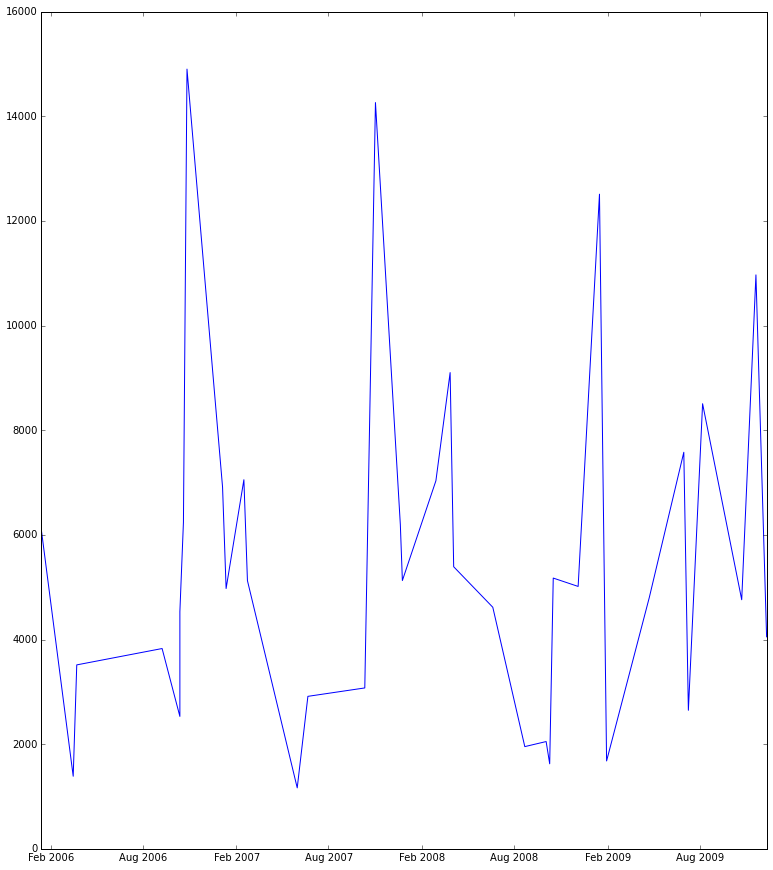

In [24]:
figure(figsize=(13,15))
trend = trend.sort(['date'])
plt.plot(trend['date'], trend['normalized_opening'])

In [173]:
trend = genre1[30:67]
trend

date  screens  \
1986 Aliens                                           1986-07-18     1437   
     Jason Lives: Friday the 13th Part VI             1986-08-01     1610   
     Police Academy 3: Back in Training               1986-03-21     1788   
     Star Trek IV: The Voyage Home                    1986-11-26     1349   
     The Fly                                          1986-08-15     1195   
     The Karate Kid, Part II                          1986-06-20     1323   
     The Texas Chainsaw Massacre 2                    1986-08-22     1474   
1987 A Nightmare on Elm Street 3: Dream Warriors      1987-02-27     1343   
     Beverly Hills Cop II                             1987-05-20     2326   
     Police Academy 4: Citizens on Patrol             1987-04-03     1750   
     Superman IV: The Quest for Peace                 1987-07-24     1511   
1988 A Nightmare on Elm Street 4: The Dream Master    1988-08-19     1765   
     Critters 2                                       1988-04-29     1114   
     Friday the 13th Part VII: The New Blood          1988-05-13     1796   
     Halloween 4: The Return of Michael Myers         1988-10-21     1679   
     Poltergeist III                                  1988-06-10     1471   
     Rambo III                                        1988-05-25     2562   
     The Naked Gun: From the Files of Police Squad!   1988-12-02     1576   
1989 A Nightmare on Elm Street 5: The Dream Child     1989-08-11     1902   
     Back to the Future Part II                       1989-11-22     1865   
     Fletch Lives                                     1989-03-17     1479   
     Friday the 13th Part VIII: Jason Takes Manhattan 1989-07-28     1683   
     Fright Night Part 2                              1989-05-19      148   
     Ghostbusters II                                  1989-06-16     2410   
     Halloween 5                                      1989-10-13     1483   
     Honey, I Shrunk the Kids                         1989-06-23     1371   
     Indiana Jones and the Last Crusade               1989-05-24     2327   
     Lethal Weapon 2                                  1989-07-07     1803   
     Police Academy 6: City Under Siege               1989-03-10     1627   
     Star Trek V: The Final Frontier                  1989-06-09     2202   
     The Fly II                                       1989-02-10     1524   
     The Little Mermaid                               1989-11-17      994   
     The War of the Roses                             1989-12-08     1259   
1990 Back to the Future Part III                      1990-05-25     2019   
     Predator 2                                       1990-11-21     1950   
     RoboCop 2                                        1990-06-22     1768   
     Rocky V                                          1990-11-16     2053   

                                                        opening  \
1986 Aliens                                            10052042   
     Jason Lives: Friday the 13th Part VI               6750837   
     Police Academy 3: Back in Training                 9049586   
     Star Trek IV: The Voyage Home                     16881888   
     The Fly                                            7007423   
     The Karate Kid, Part II                           12652336   
     The Texas Chainsaw Massacre 2                      2822439   
1987 A Nightmare on Elm Street 3: Dream Warriors        8880555   
     Beverly Hills Cop II                              26348555   
     Police Academy 4: Citizens on Patrol               8482487   
     Superman IV: The Quest for Peace                   5683122   
1988 A Nightmare on Elm Street 4: The Dream Master     12833403   
     Critters 2                                         1898751   
     Friday the 13th Part VII: The New Blood            8245038   
     Halloween 4: The Return of Michael Myers           6831250   
     Poltergeist III                                    43443

In [186]:
trend['date']

1986  Police Academy 3: Back in Training                 1986-03-21
      The Karate Kid, Part II                            1986-06-20
      Aliens                                             1986-07-18
      Jason Lives: Friday the 13th Part VI               1986-08-01
      The Fly                                            1986-08-15
      The Texas Chainsaw Massacre 2                      1986-08-22
      Star Trek IV: The Voyage Home                      1986-11-26
1987  A Nightmare on Elm Street 3: Dream Warriors        1987-02-27
      Police Academy 4: Citizens on Patrol               1987-04-03
      Beverly Hills Cop II                               1987-05-20
      Superman IV: The Quest for Peace                   1987-07-24
1988  Critters 2                                         1988-04-29
      Friday the 13th Part VII: The New Blood            1988-05-13
      Rambo III                                          1988-05-25
      Poltergeist III                           

In [255]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('1986-03-21'))

TypeError: 'int' object is not callable

In [265]:
trend.dtypes

date                  datetime64[ns]
screens                        int64
opening                        int64
normalized_opening           float64
time_delta                    object
time_delta_num                object
dtype: object

In [244]:
trend

date  screens  \
1986 Police Academy 3: Back in Training               1986-03-21     1788   
     The Karate Kid, Part II                          1986-06-20     1323   
     Aliens                                           1986-07-18     1437   
     Jason Lives: Friday the 13th Part VI             1986-08-01     1610   
     The Fly                                          1986-08-15     1195   
     The Texas Chainsaw Massacre 2                    1986-08-22     1474   
     Star Trek IV: The Voyage Home                    1986-11-26     1349   
1987 A Nightmare on Elm Street 3: Dream Warriors      1987-02-27     1343   
     Police Academy 4: Citizens on Patrol             1987-04-03     1750   
     Beverly Hills Cop II                             1987-05-20     2326   
     Superman IV: The Quest for Peace                 1987-07-24     1511   
1988 Critters 2                                       1988-04-29     1114   
     Friday the 13th Part VII: The New Blood          1988-05-13     1796   
     Rambo III                                        1988-05-25     2562   
     Poltergeist III                                  1988-06-10     1471   
     A Nightmare on Elm Street 4: The Dream Master    1988-08-19     1765   
     Halloween 4: The Return of Michael Myers         1988-10-21     1679   
     The Naked Gun: From the Files of Police Squad!   1988-12-02     1576   
1989 The Fly II                                       1989-02-10     1524   
     Police Academy 6: City Under Siege               1989-03-10     1627   
     Fletch Lives                                     1989-03-17     1479   
     Fright Night Part 2                              1989-05-19      148   
     Indiana Jones and the Last Crusade               1989-05-24     2327   
     Star Trek V: The Final Frontier                  1989-06-09     2202   
     Ghostbusters II                                  1989-06-16     2410   
     Honey, I Shrunk the Kids                         1989-06-23     1371   
     Lethal Weapon 2                                  1989-07-07     1803   
     Friday the 13th Part VIII: Jason Takes Manhattan 1989-07-28     1683   
     A Nightmare on Elm Street 5: The Dream Child     1989-08-11     1902   
     Halloween 5                                      1989-10-13     1483   
     The Little Mermaid                               1989-11-17      994   
     Back to the Future Part II                       1989-11-22     1865   
     The War of the Roses                             1989-12-08     1259   
1990 Back to the Future Part III                      1990-05-25     2019   
     RoboCop 2                                        1990-06-22     1768   
     Rocky V                                          1990-11-16     2053   
     Predator 2                                       1990-11-21     1950   

                                                        opening  \
1986 Police Academy 3: Back in Training                 9049586   
     The Karate Kid, Part II                           12652336   
     Aliens                                            10052042   
     Jason Lives: Friday the 13th Part VI               6750837   
     The Fly                                            7007423   
     The Texas Chainsaw Massacre 2                      2822439   
     Star Trek IV: The Voyage Home                     16881888   
1987 A Nightmare on Elm Street 3: Dream Warriors        8880555   
     Police Academy 4: Citizens on Patrol               8482487   
     Beverly Hills Cop II                              26348555   
     Superman IV: The Quest for Peace                   5683122   
1988 Critters 2                                         1898751   
     Friday the 13th Part VII: The New Blood            8245038   
     Rambo III                                         13034238   
     Poltergeist III                                    4344308   
     A Nightmare on Elm Street 4: The Dream Master     128334

In [266]:
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

In [269]:
trend.dtypes

date                  datetime64[ns]
screens                        int64
opening                        int64
normalized_opening           float64
time_delta                    object
time_delta_num                 int64
dtype: object

In [281]:
sort_season(11)

True


In [288]:
def sort_season(x):
    if x in [11, 12, 1]:
        return 4
    if x in [5, 6, 7, 8]:
        return 2
    if x in [9, 10,]:
        return 3
    if x in [2, 3, 4,]:
        return 1
    

In [289]:
trend['season']=trend['date'].apply(lambda x: sort_season(x.month))

In [290]:
trend

date  screens  \
1986 Police Academy 3: Back in Training               1986-03-21     1788   
     The Karate Kid, Part II                          1986-06-20     1323   
     Aliens                                           1986-07-18     1437   
     Jason Lives: Friday the 13th Part VI             1986-08-01     1610   
     The Fly                                          1986-08-15     1195   
     The Texas Chainsaw Massacre 2                    1986-08-22     1474   
     Star Trek IV: The Voyage Home                    1986-11-26     1349   
1987 A Nightmare on Elm Street 3: Dream Warriors      1987-02-27     1343   
     Police Academy 4: Citizens on Patrol             1987-04-03     1750   
     Beverly Hills Cop II                             1987-05-20     2326   
     Superman IV: The Quest for Peace                 1987-07-24     1511   
1988 Critters 2                                       1988-04-29     1114   
     Friday the 13th Part VII: The New Blood          1988-05-13     1796   
     Rambo III                                        1988-05-25     2562   
     Poltergeist III                                  1988-06-10     1471   
     A Nightmare on Elm Street 4: The Dream Master    1988-08-19     1765   
     Halloween 4: The Return of Michael Myers         1988-10-21     1679   
     The Naked Gun: From the Files of Police Squad!   1988-12-02     1576   
1989 The Fly II                                       1989-02-10     1524   
     Police Academy 6: City Under Siege               1989-03-10     1627   
     Fletch Lives                                     1989-03-17     1479   
     Fright Night Part 2                              1989-05-19      148   
     Indiana Jones and the Last Crusade               1989-05-24     2327   
     Star Trek V: The Final Frontier                  1989-06-09     2202   
     Ghostbusters II                                  1989-06-16     2410   
     Honey, I Shrunk the Kids                         1989-06-23     1371   
     Lethal Weapon 2                                  1989-07-07     1803   
     Friday the 13th Part VIII: Jason Takes Manhattan 1989-07-28     1683   
     A Nightmare on Elm Street 5: The Dream Child     1989-08-11     1902   
     Halloween 5                                      1989-10-13     1483   
     The Little Mermaid                               1989-11-17      994   
     Back to the Future Part II                       1989-11-22     1865   
     The War of the Roses                             1989-12-08     1259   
1990 Back to the Future Part III                      1990-05-25     2019   
     RoboCop 2                                        1990-06-22     1768   
     Rocky V                                          1990-11-16     2053   
     Predator 2                                       1990-11-21     1950   

                                                        opening  \
1986 Police Academy 3: Back in Training                 9049586   
     The Karate Kid, Part II                           12652336   
     Aliens                                            10052042   
     Jason Lives: Friday the 13th Part VI               6750837   
     The Fly                                            7007423   
     The Texas Chainsaw Massacre 2                      2822439   
     Star Trek IV: The Voyage Home                     16881888   
1987 A Nightmare on Elm Street 3: Dream Warriors        8880555   
     Police Academy 4: Citizens on Patrol               8482487   
     Beverly Hills Cop II                              26348555   
     Superman IV: The Quest for Peace                   5683122   
1988 Critters 2                                         1898751   
     Friday the 13th Part VII: The New Blood            8245038   
     Rambo III                                         13034238   
     Poltergeist III                                    4344308   
     A Nightmare on Elm Street 4: The Dream Master     128334

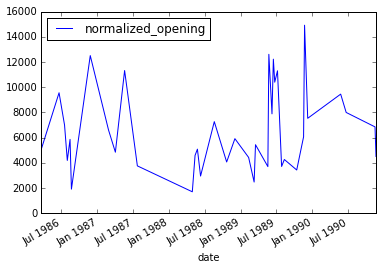

In [187]:

#figure(figsize=(13,15))
#trend = trend.sort(['date'])
trend.plot(x = 'date', y = 'normalized_opening')
#plt.plot(trend['date'], trend['normalized_opening'], kind="scatter")

In [190]:
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [307]:
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season', data = trend.reset_index(), return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')

In [308]:
X

,Intercept,time_delta_num,season
0,1,0,1
1,1,91,2
2,1,119,2
3,1,133,2
4,1,147,2
5,1,154,2
6,1,250,4
7,1,343,1
8,1,378,1
9,1,425,2


In [310]:
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')

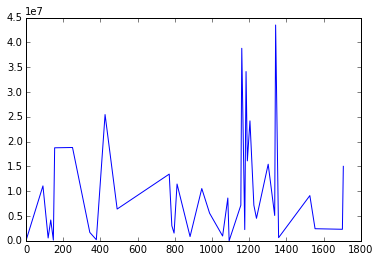

In [325]:
plot(X['time_delta_num'], (fitted.resid)**2)

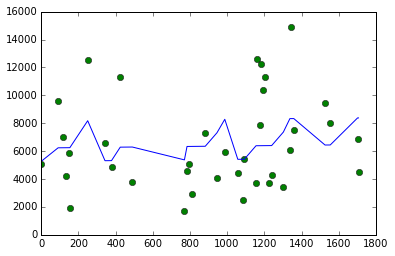

In [311]:
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')

In [77]:
from sklearn import datasets, linear_model

In [78]:
regr = linear_model.LinearRegression()

In [79]:
plt.plot(trend['normalized_opening'], regr.predict(trend['normalized_opening']), color='blue', linewidth=3)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [61]:
print result.params

Intercept                                   5061.289709
date[T.Timestamp('1986-06-20 00:00:00')]    4502.078394
date[T.Timestamp('1986-07-18 00:00:00')]    1933.868259
date[T.Timestamp('1986-08-01 00:00:00')]    -868.223250
date[T.Timestamp('1986-08-15 00:00:00')]     802.662592
date[T.Timestamp('1986-08-22 00:00:00')]   -3146.473563
date[T.Timestamp('1986-11-26 00:00:00')]    7453.082418
date[T.Timestamp('1987-02-27 00:00:00')]    1551.186091
date[T.Timestamp('1987-04-03 00:00:00')]    -214.154281
date[T.Timestamp('1987-05-20 00:00:00')]    6266.549930
date[T.Timestamp('1987-07-24 00:00:00')]   -1300.123594
date[T.Timestamp('1988-04-29 00:00:00')]   -3356.845364
date[T.Timestamp('1988-05-13 00:00:00')]    -470.511313
date[T.Timestamp('1988-05-25 00:00:00')]      26.234881
date[T.Timestamp('1988-06-10 00:00:00')]   -2107.987194
date[T.Timestamp('1988-08-19 00:00:00')]    2209.760149
date[T.Timestamp('1988-10-21 00:00:00')]    -992.647660
date[T.Timestamp('1988-12-02 00:00:00')]     859

In [62]:
print result.summary()

                            OLS Regression Results                            
Dep. Variable:     normalized_opening   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Wed, 07 Oct 2015   Prob (F-statistic):                nan
Time:                        14:52:02   Log-Likelihood:                 903.72
No. Observations:                  37   AIC:                            -1733.
Df Residuals:                       0   BIC:                            -1674.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [81]:
from __future__ import division
from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
from numpy import linspace, loadtxt, ones, convolve
import numpy as numpy



def movingaverage(interval, window_size):
    window= numpy.ones(int(window_size))/float(window_size)
    return numpy.convolve(interval, window, 'same')

y = trend['normalized_opening']
x = trend['date']


plot(x,y,"k.")
y_av = movingaverage(y, 10)
plot(x, y_av,"r")
xlim(0,1000)
xlabel("Months since Jan 1749.")
ylabel("No. of Sun spots")
grid(True)
show()

ValueError: ordinal must be >= 1

In [83]:
import pandas.io.data as web

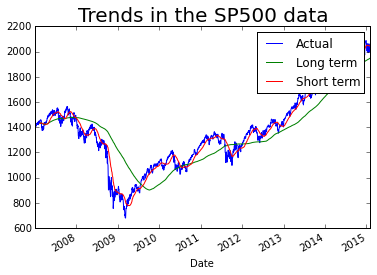

In [84]:
spc = web.DataReader(name = "^GSPC", data_source = 'yahoo', start = '2007-1-1', end = '2015-2-2')
#spc.to_csv("SP500.csv")         # Function to save a data frame for offline analysis  
spc.tail()

# Compute rolling statistics
spc['MA42'] = pd.rolling_mean(spc['Open'], window = 42, min_periods = 30)
spc['MA252'] = pd.rolling_mean(spc['Open'], window = 252,  min_periods = 30)
spc[['Open', 'MA252', 'MA42']].plot()
plt.legend(["Actual", "Long term", "Short term"])
plt.title('Trends in the SP500 data', fontsize = 20)

In [166]:
trend['trend_ma'] = pd.rolling_mean(trend['normalized_opening'], window = 2, min_periods = 1)

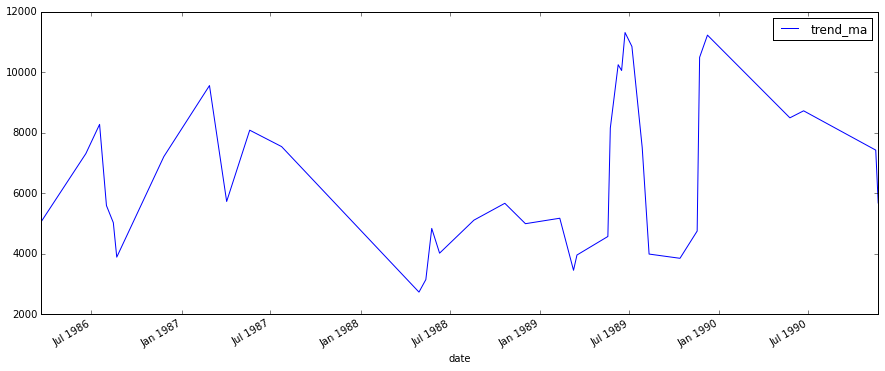

In [169]:

trend[['trend_ma']].plot(figsize=(15, 6))

In [161]:
trend.describe()

,screens,opening,normalized_opening,trend_ma
count,37.000000,37.000000,37.000000,18.000000
mean,1646.918919,11358705.027027,6581.422591,6211.089276
std,445.397100,7533617.865653,3355.637965,409.507972
min,148.000000,548231.000000,1704.444345,5468.377858
25%,1437.000000,6750837.000000,4193.066460,5930.711826
50%,1627.000000,8880555.000000,5863.952301,6293.686768
75%,1865.000000,14145411.000000,8000.798077,6463.173071
max,2562.000000,29472894.000000,14925.000000,6847.196207


In [123]:
print type(trend.date[1])

<class 'pandas.tslib.Timestamp'>


In [180]:
trend1= trend.set_index(['date'])

In [182]:
trend1

,screens,opening,normalized_opening
date,,,
1986-03-21,1788,9049586,5061.289709
1986-06-20,1323,12652336,9563.368103
1986-07-18,1437,10052042,6995.157968
1986-08-01,1610,6750837,4193.066460
1986-08-15,1195,7007423,5863.952301
1986-08-22,1474,2822439,1914.816147
1986-11-26,1349,16881888,12514.372128
1987-02-27,1343,8880555,6612.475800
1987-04-03,1750,8482487,4847.135429
